<a href="https://colab.research.google.com/github/anjelammcgraw/Denoising-Diffusion-Probabilistic-Model-DDPM-from-Scratch/blob/main/AddingContextDDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision tqdm matplotlib numpy ipython pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML

Diffusion Utilities

In [3]:
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

In [4]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def norm_torch(x_all):
    # runs unity norm on all timesteps of all samples
    # input is (n_samples, 3,h,w), the torch image format
    x = x_all.cpu().numpy()
    xmax = x.max((2,3))
    xmin = x.min((2,3))
    xmax = np.expand_dims(xmax,(2,3))
    xmin = np.expand_dims(xmin,(2,3))
    nstore = (x - xmin)/(xmax - xmin)
    return torch.from_numpy(nstore)

def gen_tst_context(n_cfeat):
    """
    Generate test context vectors
    """
    vec = torch.tensor([
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0]]      # human, non-human, food, spell, side-facing
    )
    return len(vec), vec

def plot_grid(x,n_sample,n_rows,save_dir,w):
    # x:(n_sample, 3, h, w)
    ncols = n_sample//n_rows
    grid = make_grid(norm_torch(x), nrow=ncols)  # curiously, nrow is number of columns.. or number of items in the row.
    save_image(grid, save_dir + f"run_image_w{w}.png")
    print('saved image at ' + save_dir + f"run_image_w{w}.png")
    return grid

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow

    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani


class CustomDataset(Dataset):
    def __init__(self, sfilename, lfilename, transform, null_context=False):
        self.sprites = np.load(sfilename)
        self.slabels = np.load(lfilename)
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

])

Setting Things Up

In [5]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [6]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

In [7]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

In [8]:
# Define the ResidualConvBlock class
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.is_res = in_channels != out_channels

    def forward(self, x):
        res = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.is_res:
            res = self.res_conv(res)

        out += res
        return self.relu(out)

# Define the ContextUnet class
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  # assume h == w. must be divisible by 4, so 28, 24, 20, 16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # Convert t to float
        t = t.float()

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [9]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [10]:
print(device)
print(nn_model)

cuda:0
ContextUnet(
  (init_conv): ResidualConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (res_conv): Conv2d(64, 64, kerne

Context

In [11]:
# reset neural network
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [12]:
# re setup optimizer
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [14]:
from google.colab import files
uploaded = files.upload()

Saving sprite_labels_nc_1788_16x16.npy to sprite_labels_nc_1788_16x16.npy
Saving sprites_1788_16x16.npy to sprites_1788_16x16.npy


In [15]:
# load dataset and construct optimizer
dataset = CustomDataset("./sprites_1788_16x16.npy", "./sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [17]:
# Define the perturb_input function
def perturb_input(x, t, noise):
    # Example perturbation: Add noise to the input data scaled by the time step
    return x + (t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * noise)

In [18]:
# training with context code
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2 )
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)

        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps, c=c)

        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()

        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
        print('saved model at ' + save_dir + f"context_model_{ep}.pth")

epoch 0


100%|██████████| 894/894 [00:16<00:00, 55.60it/s]


saved model at ./weights/context_model_0.pth
epoch 1


100%|██████████| 894/894 [00:14<00:00, 61.00it/s]


epoch 2


100%|██████████| 894/894 [00:14<00:00, 60.86it/s]


epoch 3


100%|██████████| 894/894 [00:14<00:00, 61.47it/s]


epoch 4


100%|██████████| 894/894 [00:14<00:00, 60.69it/s]


saved model at ./weights/context_model_4.pth
epoch 5


100%|██████████| 894/894 [00:14<00:00, 60.97it/s]


epoch 6


100%|██████████| 894/894 [00:14<00:00, 60.11it/s]


epoch 7


100%|██████████| 894/894 [00:14<00:00, 60.79it/s]


epoch 8


100%|██████████| 894/894 [00:14<00:00, 60.60it/s]


saved model at ./weights/context_model_8.pth
epoch 9


100%|██████████| 894/894 [00:14<00:00, 60.69it/s]


epoch 10


100%|██████████| 894/894 [00:14<00:00, 61.58it/s]


epoch 11


100%|██████████| 894/894 [00:14<00:00, 60.74it/s]


epoch 12


100%|██████████| 894/894 [00:15<00:00, 56.18it/s]


saved model at ./weights/context_model_12.pth
epoch 13


100%|██████████| 894/894 [00:14<00:00, 61.16it/s]


epoch 14


100%|██████████| 894/894 [00:14<00:00, 60.31it/s]


epoch 15


100%|██████████| 894/894 [00:14<00:00, 61.28it/s]


epoch 16


100%|██████████| 894/894 [00:14<00:00, 60.46it/s]


saved model at ./weights/context_model_16.pth
epoch 17


100%|██████████| 894/894 [00:14<00:00, 60.45it/s]


epoch 18


100%|██████████| 894/894 [00:14<00:00, 61.68it/s]


epoch 19


100%|██████████| 894/894 [00:14<00:00, 60.32it/s]


epoch 20


100%|██████████| 894/894 [00:14<00:00, 60.34it/s]


saved model at ./weights/context_model_20.pth
epoch 21


100%|██████████| 894/894 [00:14<00:00, 60.06it/s]


epoch 22


100%|██████████| 894/894 [00:14<00:00, 61.19it/s]


epoch 23


100%|██████████| 894/894 [00:15<00:00, 59.41it/s]


epoch 24


100%|██████████| 894/894 [00:15<00:00, 57.28it/s]


saved model at ./weights/context_model_24.pth
epoch 25


100%|██████████| 894/894 [00:14<00:00, 59.96it/s]


epoch 26


100%|██████████| 894/894 [00:14<00:00, 60.55it/s]


epoch 27


100%|██████████| 894/894 [00:14<00:00, 60.30it/s]


epoch 28


100%|██████████| 894/894 [00:14<00:00, 60.48it/s]


saved model at ./weights/context_model_28.pth
epoch 29


100%|██████████| 894/894 [00:14<00:00, 60.16it/s]


epoch 30


100%|██████████| 894/894 [00:14<00:00, 61.33it/s]


epoch 31


100%|██████████| 894/894 [00:14<00:00, 61.38it/s]

saved model at ./weights/context_model_31.pth


In [25]:
# load in one of the pretrained model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/context_model_0.pth", map_location=device))
nn_model.eval()
print("Loaded in Context Model")

Loaded in Context Model


Sampling with Context

In [26]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [27]:
# sample with context using standard algorithm
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

<Figure size 640x480 with 0 Axes>

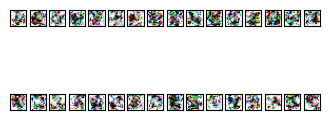

In [29]:
# visualize samples with randomly selected context
plt.clf()
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()
samples, intermediate = sample_ddpm_context(32, ctx)
animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm_context.to_jshtml())

def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

show_images(samples)

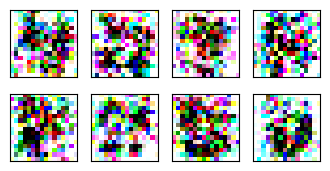

In [30]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

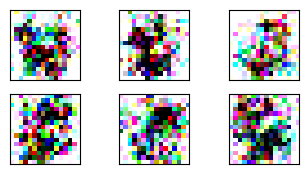

In [31]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],
    [0,0,0.6,0.4,0],
    [1,0,0,0,1],
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

# Acknowledgments
Sprites by ElvGames, [FrootsnVeggies](https://zrghr.itch.io/froots-and-veggies-culinary-pixels) and  [kyrise](https://kyrise.itch.io/)   
This code is modified from, https://github.com/cloneofsimo/minDiffusion   
Diffusion model is based on [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) and [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502)
